- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "bonus" - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import scale,StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('employee_churn_data.csv')

In [4]:
# 30% of our data is positive class (left== yes)
len(df[df['left'] == 'yes']) / len(df)

0.2918238993710692

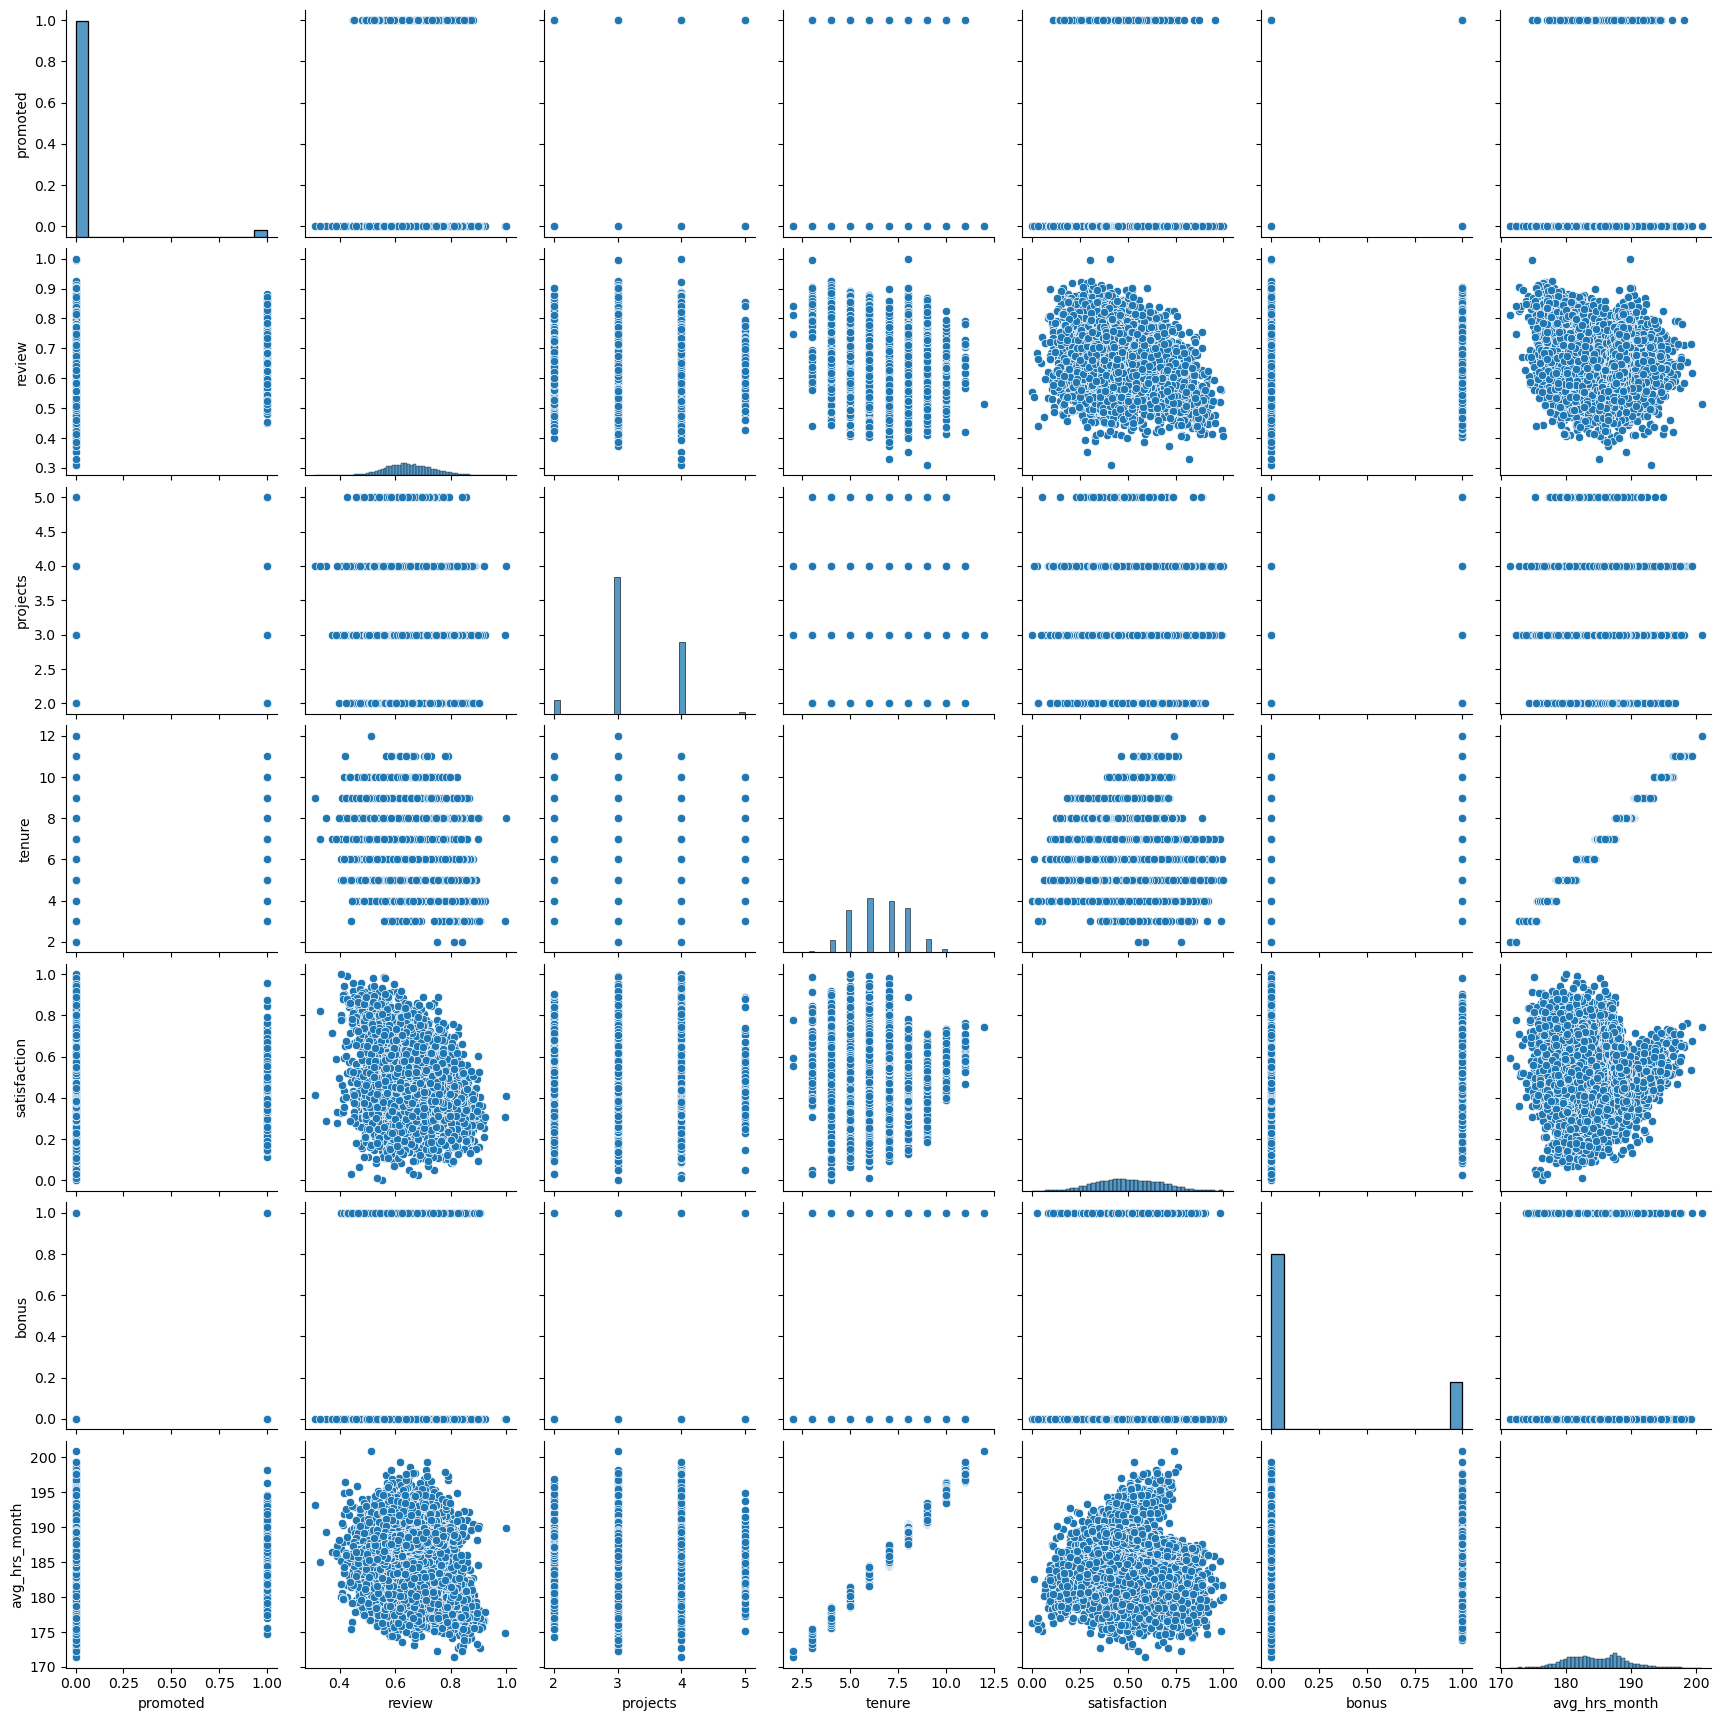

In [5]:
# strong correlation between Tenrue and Avg_monthly working hours... and Nothing else special!
sns.pairplot(df)

In [5]:
# by department, promoted, salary level, tenure, bonus 

In [12]:
# df4 = turn 'left' to dummies
temp = pd.get_dummies(df['left'])
df4=pd.concat([df,temp],axis=1)
df4

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,no,yes
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no,1,0
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no,1,0
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no,1,0
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no,1,0
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes,0,1
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes,0,1
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes,0,1
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes,0,1


In [11]:
df4

NameError: name 'df4' is not defined

# Churn Rate by each Variable

### <font color='blue'> check-points</font>
- 'Promoted or not' has bigger impact on churn than 'Bonus'
- IT, Logistics, Retail have slightly higher churn rate, but overall no big differences.
- Tenure shows some patterns, 2-3 years (junior career jump-up) and 7-8 years (manager) has higher churn rate.

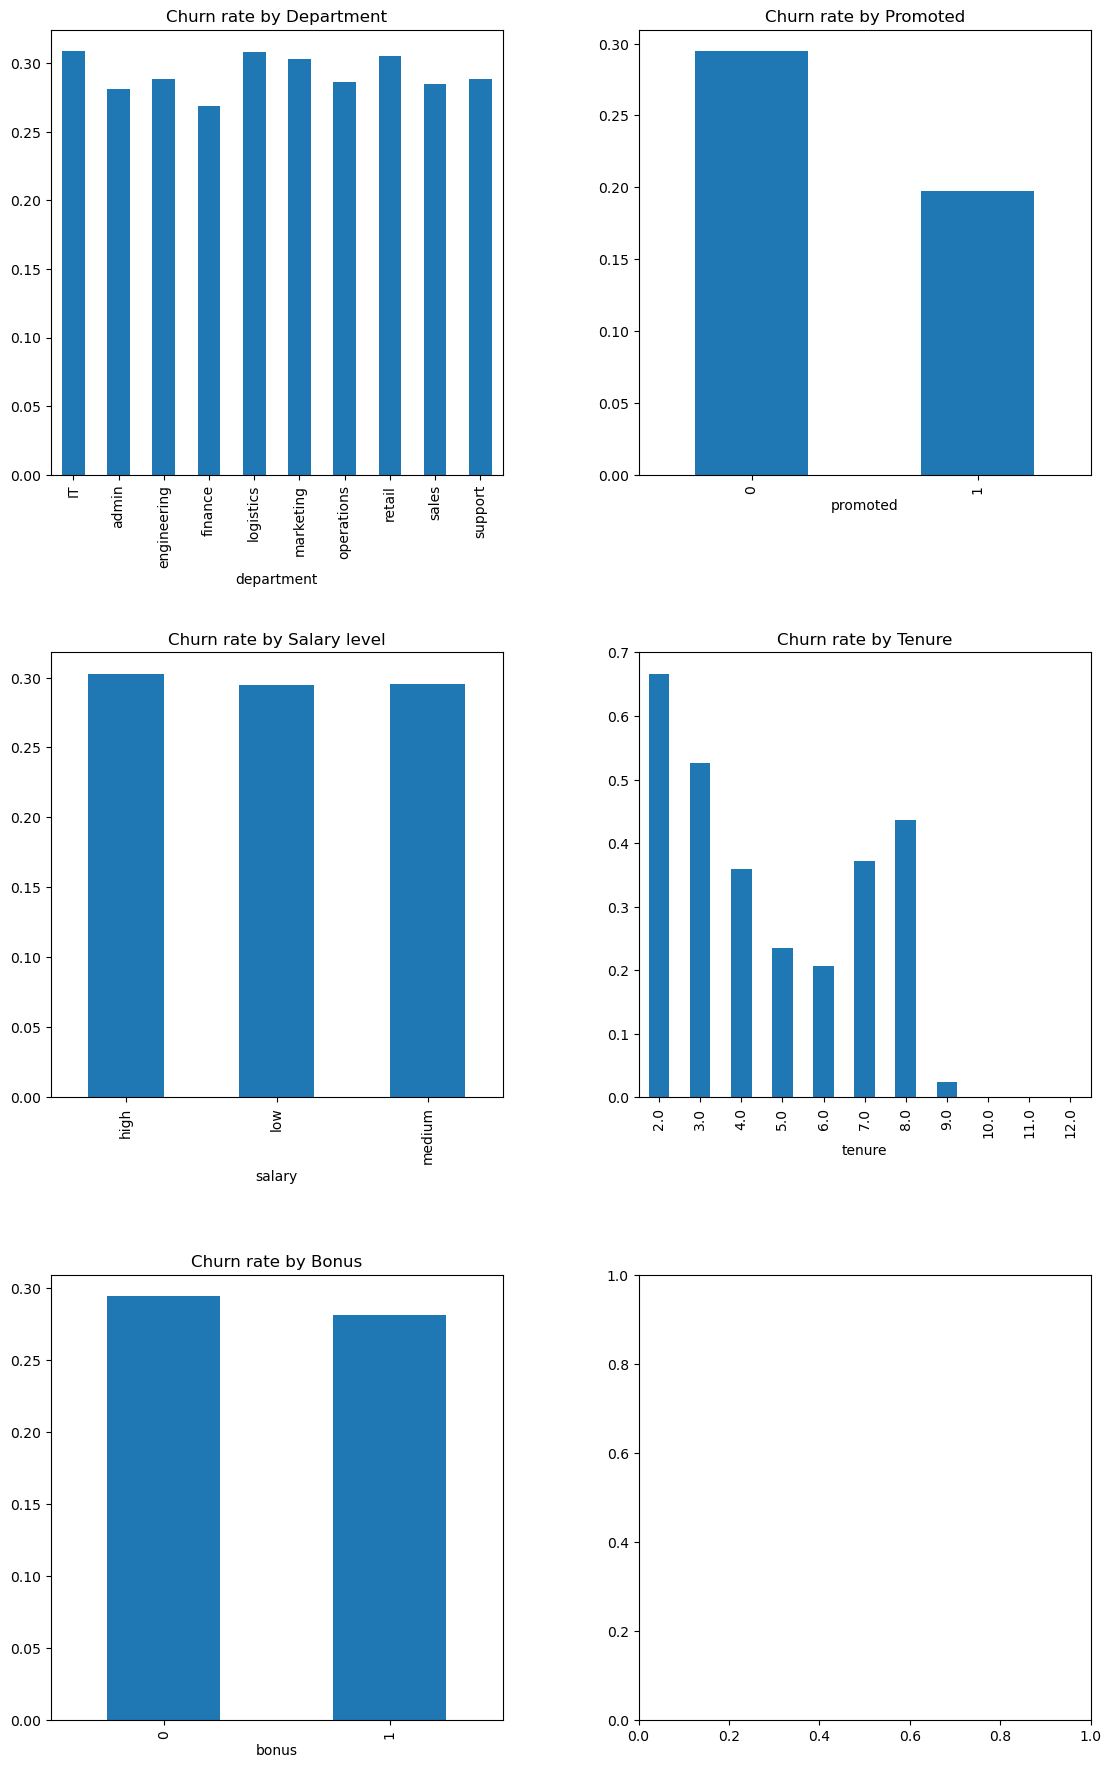

In [80]:
plt.figure(figsize=(13,13))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)

# churn rate by department
plt.subplot(3,2,1)
churn_by_depart = df4.groupby('department')['yes'].sum() / df4.groupby('department')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by Department')

# churn rate by promoted
plt.subplot(3,2,2)
churn_by_depart = df4.groupby('promoted')['yes'].sum() / df4.groupby('promoted')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by Promoted')

# churn rate by n of projects
plt.subplot(3,2,3)
churn_by_depart = df4.groupby('projects')['yes'].sum() / df4.groupby('projects')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by N of projects')

# churn rate by salary level
plt.subplot(3,2,3)
churn_by_depart = df4.groupby('salary')['yes'].sum() / df4.groupby('salary')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by Salary level')

# churn rate by Tenure
plt.subplot(3,2,4)
churn_by_depart = df4.groupby('tenure')['yes'].sum() / df4.groupby('tenure')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by Tenure')

# churn rate by Bonus
plt.subplot(3,2,5)
churn_by_depart = df4.groupby('bonus')['yes'].sum() / df4.groupby('bonus')['yes'].count()
churn_by_depart.plot(kind='bar')
plt.title('Churn rate by Bonus')

plt.subplot(3,2,6)
plt.show()

# Feature Importance- random forest (to get an idea of the variable that actually matters)

### <font color = blue> what would be the important predictors? tried to get some hints from modeling results</font>
- Satisfaction, Review, avg_hrs_month, tenure..!

In [8]:
temp = pd.get_dummies(df[["department","salary", "left"]])
df.drop(["department","salary","left"],axis=1,inplace=True)
df2=pd.concat([df,temp],axis=1)
df2.drop("left_no",axis=1,inplace=True)

FEATURE IMPORTANCE:


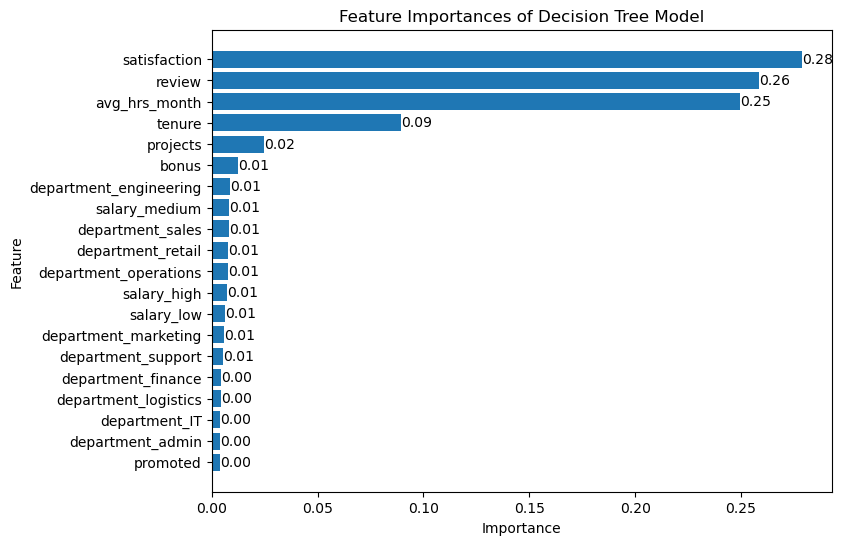

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

X=df2.drop("left_yes",axis=1)
y=df2["left_yes"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

rf=RandomForestClassifier().fit(X_train,y_train)

# Get the feature importances from the best model
feature_importances = rf.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': df2.columns[:-1], 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=True)

#Plot Feature Importance
print("FEATURE IMPORTANCE:")

# Create a bar plot of the feature importances
plt.figure(figsize=(8, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])

# Add value annotations to the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, i, f"{width:.2f}", color='black', va='center')
    
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Decision Tree Model')
plt.show()

# Convert varaibles with multiple values to range value

### <font color=blue> Satisfaction, Review, avg_hrs_month </font>

- 1. Satisfaction

In [10]:
# Due to non-overlapping values of cashback amount, set the scope for cashback to catch the trend better
import numpy as np

conditions = [
    df4['satisfaction'] < 0.10,
    (df4['satisfaction'] >= 0.10) & (df4['satisfaction'] < 0.20),
    (df4['satisfaction'] >= 0.20) & (df4['satisfaction'] < 0.30),
    (df4['satisfaction'] >= 0.30) & (df4['satisfaction'] < 0.40),
    (df4['satisfaction'] >= 0.40) & (df4['satisfaction'] < 0.50),
    (df4['satisfaction'] >= 0.50) & (df4['satisfaction'] < 0.60),
    (df4['satisfaction'] >= 0.60) & (df4['satisfaction'] < 0.70),
    (df4['satisfaction'] >= 0.70) & (df4['satisfaction'] < 0.80),
    (df4['satisfaction'] >= 0.80) & (df4['satisfaction'] < 0.90),
    df4['satisfaction'] >= 0.90
]

choices = [' - 0.10', '0.10-0.20','0.20-0.30','0.30-0.40','0.40-0.50','0.50-0.60','0.60-0.70','0.70-0.80','0.80-0.90','0.90']

df4['satisfaction_range'] = np.select(conditions, choices, default='unknown')

print(df4)

      department  promoted    review  projects  salary  tenure  satisfaction  \
0     operations         0  0.577569         3     low     5.0      0.626759   
1     operations         0  0.751900         3  medium     6.0      0.443679   
2        support         0  0.722548         3  medium     6.0      0.446823   
3      logistics         0  0.675158         4    high     8.0      0.440139   
4          sales         0  0.676203         3    high     5.0      0.577607   
...          ...       ...       ...       ...     ...     ...           ...   
9535  operations         0  0.610988         4  medium     8.0      0.543641   
9536   logistics         0  0.746887         3  medium     8.0      0.549048   
9537  operations         0  0.557980         3     low     7.0      0.705425   
9538          IT         0  0.584446         4  medium     8.0      0.607287   
9539     finance         0  0.626373         3     low     7.0      0.706455   

      bonus  avg_hrs_month left  no  ye

### <font color='blue'> Churn Rate by Satisfaction_range</font>
- It is not pefectly aligned with the obvious assumption 'employee with lower satisfaction would highly likely to quit'
- Interesting point here is that even with relatively high satisfaction score(70-90), a large portion of employee quit.
- Perhaps they would be the productive, capable and also "happy" employees, who are highly likely to be taken valuable by other companies as well (which made them move to other companys)
- Or maybe they were hiding their real unsatisfaction toward compnay when doing survey, because they were serioulsy thinking to quit job and afraid of being caught :)

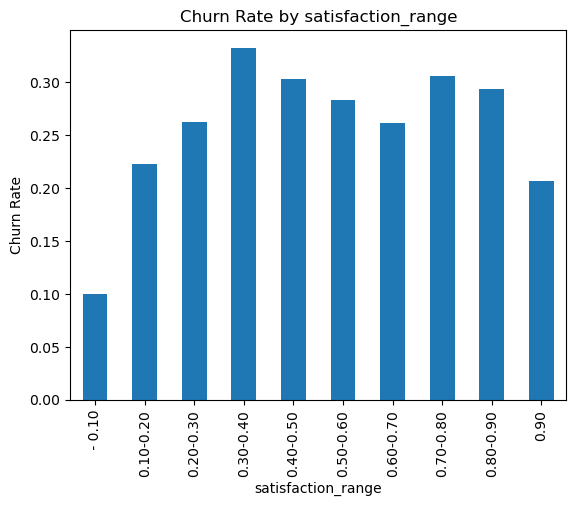

In [11]:
satisfaction = df4.groupby('satisfaction_range')['yes'].mean()
satisfaction.plot(kind='bar')

# Add labels and title
plt.xlabel('satisfaction_range')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by satisfaction_range')

# Display the plot
plt.show()

- 2. Review

In [12]:
# Due to non-overlapping values of cashback amount, set the scope for cashback to catch the trend better
import numpy as np

conditions = [
    (df4['review'] >= 0.30) & (df4['review'] < 0.40),
    (df4['review'] >= 0.40) & (df4['review'] < 0.50),
    (df4['review'] >= 0.50) & (df4['review'] < 0.60),
    (df4['review'] >= 0.60) & (df4['review'] < 0.70),
    (df4['review'] >= 0.70) & (df4['review'] < 0.80),
    (df4['review'] >= 0.80) & (df4['review'] < 0.90),
    df4['review'] >= 0.90
]

choices = ['0.30-0.40','0.40-0.50','0.50-0.60','0.60-0.70','0.70-0.80','0.80-0.90','over 0.90']

df4['review_range'] = np.select(conditions, choices, default='unknown')

print(df4)

      department  promoted    review  projects  salary  tenure  satisfaction  \
0     operations         0  0.577569         3     low     5.0      0.626759   
1     operations         0  0.751900         3  medium     6.0      0.443679   
2        support         0  0.722548         3  medium     6.0      0.446823   
3      logistics         0  0.675158         4    high     8.0      0.440139   
4          sales         0  0.676203         3    high     5.0      0.577607   
...          ...       ...       ...       ...     ...     ...           ...   
9535  operations         0  0.610988         4  medium     8.0      0.543641   
9536   logistics         0  0.746887         3  medium     8.0      0.549048   
9537  operations         0  0.557980         3     low     7.0      0.705425   
9538          IT         0  0.584446         4  medium     8.0      0.607287   
9539     finance         0  0.626373         3     low     7.0      0.706455   

      bonus  avg_hrs_month left  no  ye

### <font color='blue'> Churn Rate by Review_range</font>
- Interesting results here! It seems that my presumption regarding the employee with high satisfaction score above, that they would be the ones who are evaluated highly by other corporations.
- "Exceptional employees usually don't stay loyal to one company "

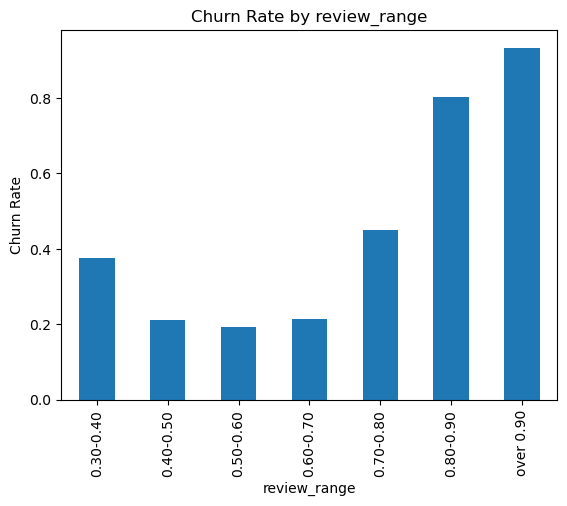

In [13]:
review = df4.groupby('review_range')['yes'].mean()
review.plot(kind='bar')

# Add labels and title
plt.xlabel('review_range')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by review_range')

# Display the plot
plt.show()

- 3. Average Working Hours of Month

In [14]:
# Due to non-overlapping values of cashback amount, set the scope for cashback to catch the trend better
import numpy as np

conditions = [
    (df4['avg_hrs_month'] >= 170) & (df4['avg_hrs_month'] < 175),
    (df4['avg_hrs_month'] >= 175) & (df4['avg_hrs_month'] < 180),
    (df4['avg_hrs_month'] >= 180) & (df4['avg_hrs_month'] < 185),
    (df4['avg_hrs_month'] >= 185) & (df4['avg_hrs_month'] < 190),
    (df4['avg_hrs_month'] >= 190) & (df4['avg_hrs_month'] < 195),
    (df4['avg_hrs_month'] >= 195) & (df4['avg_hrs_month'] < 200),
    df4['review'] >= 200
]

choices = ['170-175','175-180','180-185','185-190', '190-195', '195-200', 'over 200']

df4['avg_hrs_month_range'] = np.select(conditions, choices, default='unknown')

print(df4)

      department  promoted    review  projects  salary  tenure  satisfaction  \
0     operations         0  0.577569         3     low     5.0      0.626759   
1     operations         0  0.751900         3  medium     6.0      0.443679   
2        support         0  0.722548         3  medium     6.0      0.446823   
3      logistics         0  0.675158         4    high     8.0      0.440139   
4          sales         0  0.676203         3    high     5.0      0.577607   
...          ...       ...       ...       ...     ...     ...           ...   
9535  operations         0  0.610988         4  medium     8.0      0.543641   
9536   logistics         0  0.746887         3  medium     8.0      0.549048   
9537  operations         0  0.557980         3     low     7.0      0.705425   
9538          IT         0  0.584446         4  medium     8.0      0.607287   
9539     finance         0  0.626373         3     low     7.0      0.706455   

      bonus  avg_hrs_month left  no  ye

### <font color='blue'> Churn Rate by Avg_hours-Month_range</font>
- When converting to day-to-day unit, the minimum group and maximum group has only 1 hour differnce of working hours daily.
- So it seems to catch a trend by each group... 
- But still we can presume from the result that 'person who is thinking to quit would put minimum amount of time on working' or 'Overworking is one of obvious reasons for employee to quit'

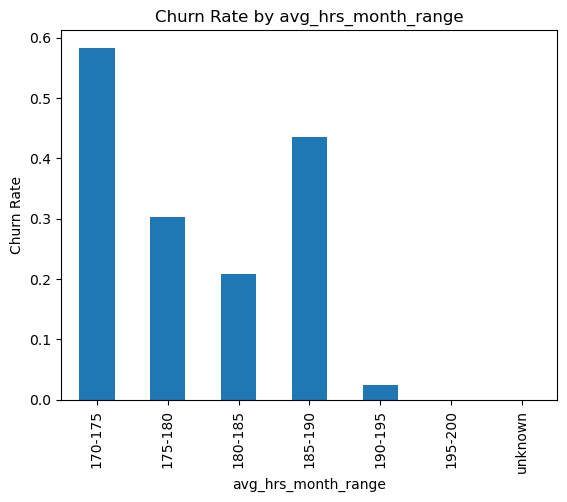

In [15]:
review = df4.groupby('avg_hrs_month_range')['yes'].mean()
review.plot(kind='bar')

# Add labels and title
plt.xlabel('avg_hrs_month_range')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by avg_hrs_month_range')

# Display the plot
plt.show()

# Churn Rate on one page

In [16]:
# defining a tuple for storing the dataframes in a containing information about the contribution each value to the customer churn.
# this was done so that we can quickly automate making such dataframes

d={}

# running loop for storing the calculating and storing the values in the relevant dataframes  
for i in df4.columns.values[[0,1,3,4,5,7,12,13,14]]:
    d[i] = pd.concat([df4.groupby(i).yes.sum(), df4[i].value_counts(), np.round(df4.groupby(i).yes.sum() * 100 / df4[i].value_counts(), 2)], axis=1)
    d[i].reset_index(level=0, inplace=True)
    d[i] = d[i].rename(columns={'index': i, 'left_yes': 'Employee_churned', i: 'Total_Employee', 0: '%_of_churn'})

In [17]:
## I should also add the portions from total cusotmers

for i in df4.columns.values[[0,1,3,4,5,7,12,13,14]]:
    print(i)
    print(d[i])
    print('-----------------------------------------------------------------------')
    print()

department
    department    yes  Total_Employee  %_of_churn
0           IT  110.0             356       30.90
1        admin  119.0             423       28.13
2  engineering  437.0            1516       28.83
3      finance  108.0             402       26.87
4    logistics  111.0             360       30.83
5    marketing  243.0             802       30.30
6   operations  436.0            1522       28.65
7       retail  471.0            1541       30.56
8        sales  537.0            1883       28.52
9      support  212.0             735       28.84
-----------------------------------------------------------------------

promoted
   promoted     yes  Total_Employee  %_of_churn
0         0  2727.0            9251       29.48
1         1    57.0             289       19.72
-----------------------------------------------------------------------

projects
   projects     yes  Total_Employee  %_of_churn
0         2   175.0             578       30.28
1         3  1720.0            5833

In [19]:
# only leaving the range column for satisfaction, review, avg_hrs_month
df5 = df4.drop(['satisfaction', 'review', 'avg_hrs_month'], axis=1)

In [23]:
# make 'salary' dummie values
temp = pd.get_dummies(df5['salary'])
df6=pd.concat([df5,temp],axis=1)
df6 = df6.drop('salary', axis =1)

In [61]:
# to prevent automatic truncation of long columns
pd.set_option('display.max_columns', None)

trendby_depart = df6.groupby(by='department')['promoted', 'projects', 'tenure', 'bonus', 'satisfaction_range', 'review_range', 'avg_hrs_month_range', 'high', 'low', 'medium', 'yes'].agg(['count', 'mean', 'sum'])

In [62]:
trendby_depart

promoted               projects                 tenure            \
               count      mean sum    count      mean   sum  count      mean   
department                                                                     
IT               356  0.022472   8      356  3.289326  1171    356  6.609551   
admin            423  0.037825  16      423  3.278960  1387    423  6.498818   
engineering     1516  0.023087  35     1516  3.263852  4948   1516  6.558047   
finance          402  0.047264  19      402  3.293532  1324    402  6.440299   
logistics        360  0.019444   7      360  3.275000  1179    360  6.527778   
marketing        802  0.042394  34      802  3.280549  2631    802  6.503741   
operations      1522  0.029566  45     1522  3.271353  4979   1522  6.608410   
retail          1541  0.033744  52     1541  3.266061  5033   1541  6.591175   
sales           1883  0.026553  50     1883  3.286245  6188   1883  6.535847   
support          735  0.031293  23      735  3.268027  2402    735  6.564626   

                     bonus                 high                    low  \
                 sum count      mean  sum count      mean    sum count   
department                                                               
IT            2353.0   356  0.221910   79   356  0.165730   59.0   356   
admin         2749.0   423  0.186761   79   423  0.158392   67.0   423   
engineering   9942.0  1516  0.211082  320  1516  0.155013  235.0  1516   
finance       2589.0   402  0.231343   93   402  0.174129   70.0   402   
logistics     2350.0   360  0.208333   75   360  0.141667   51.0   360   
marketing     5216.0   802  0.219451  176   802  0.167082  134.0   802   
operations   10058.0  1522  0.206965  315  1522  0.157687  240.0  1522   
retail       10157.0  1541  0.218689  337  1541  0.161583  249.0  1541   
sales        12307.0  1883  0.211896  399  1883  0.164631  310.0  1883   
support       4825.0   735  0.204082  150   735  0.180952  133.0   735   

                             medium                     yes                   
                 mean    sum  count      mean     sum count      mean    sum  
department                                                                    
IT           0.120787   43.0    356  0.713483   254.0   356  0.308989  110.0  
admin        0.118203   50.0    423  0.723404   306.0   423  0.281324  119.0  
engineering  0.134565  204.0   1516  0.710422  1077.0  1516  0.288259  437.0  
finance      0.144279   58.0    402  0.681592   274.0   402  0.268657  108.0  
logistics    0.138889   50.0    360  0.719444   259.0   360  0.308333  111.0  
marketing    0.172070  138.0    802  0.660848   530.0   802  0.302993  243.0  
operations   0.145204  221.0   1522  0.697109  1061.0  1522  0.286465  436.0  
retail       0.149254  230.0   1541  0.689163  1062.0  1541  0.305646  471.0  
sales        0.153478  289.0   1883  0.681891  1284.0  1883  0.285183  537.0  
support      0.133333   98.0    735  0.685714   504.0   735  0.288435  212.0

# Status by Department

### <font color='blue'> Check-point </font>
- All departments have similar Churn rate. Minimum : finance (27%) |  Maximum : IT, Retail
- In terms of predictors, 'promotion status', 'Salary high', 'Salary Low' show some different trends among departments.
 : Finance shows the lowest churn, perhaps because the largest number of people got promoted recently.
 
 : more ....

In [65]:
depart_status = round(trendby_depart.iloc[:, [1, 4, 7, 10, 13, 16, 19, 22, 0]],2)
depart_status['% versus total employee'] = round(depart_status.iloc[:, 8] / len(df6),2)
depart_status = depart_status.droplevel(1, axis=1)
depart_status.columns = ['promoted', 'projects', 'tenure', 'bonus', 'sal_high', 'sal_low', 'sal_mid', 'CHURN', 'N of employees', 'total ratio']
depart_status

,promoted,projects,tenure,bonus,sal_high,sal_low,sal_mid,CHURN,N of employees,total ratio
department,,,,,,,,,,
IT,0.02,3.29,6.61,0.22,0.17,0.12,0.71,0.31,356,0.04
admin,0.04,3.28,6.50,0.19,0.16,0.12,0.72,0.28,423,0.04
engineering,0.02,3.26,6.56,0.21,0.16,0.13,0.71,0.29,1516,0.16
finance,0.05,3.29,6.44,0.23,0.17,0.14,0.68,0.27,402,0.04
logistics,0.02,3.28,6.53,0.21,0.14,0.14,0.72,0.31,360,0.04
marketing,0.04,3.28,6.50,0.22,0.17,0.17,0.66,0.30,802,0.08
operations,0.03,3.27,6.61,0.21,0.16,0.15,0.70,0.29,1522,0.16
retail,0.03,3.27,6.59,0.22,0.16,0.15,0.69,0.31,1541,0.16
sales,0.03,3.29,6.54,0.21,0.16,0.15,0.68,0.29,1883,0.20


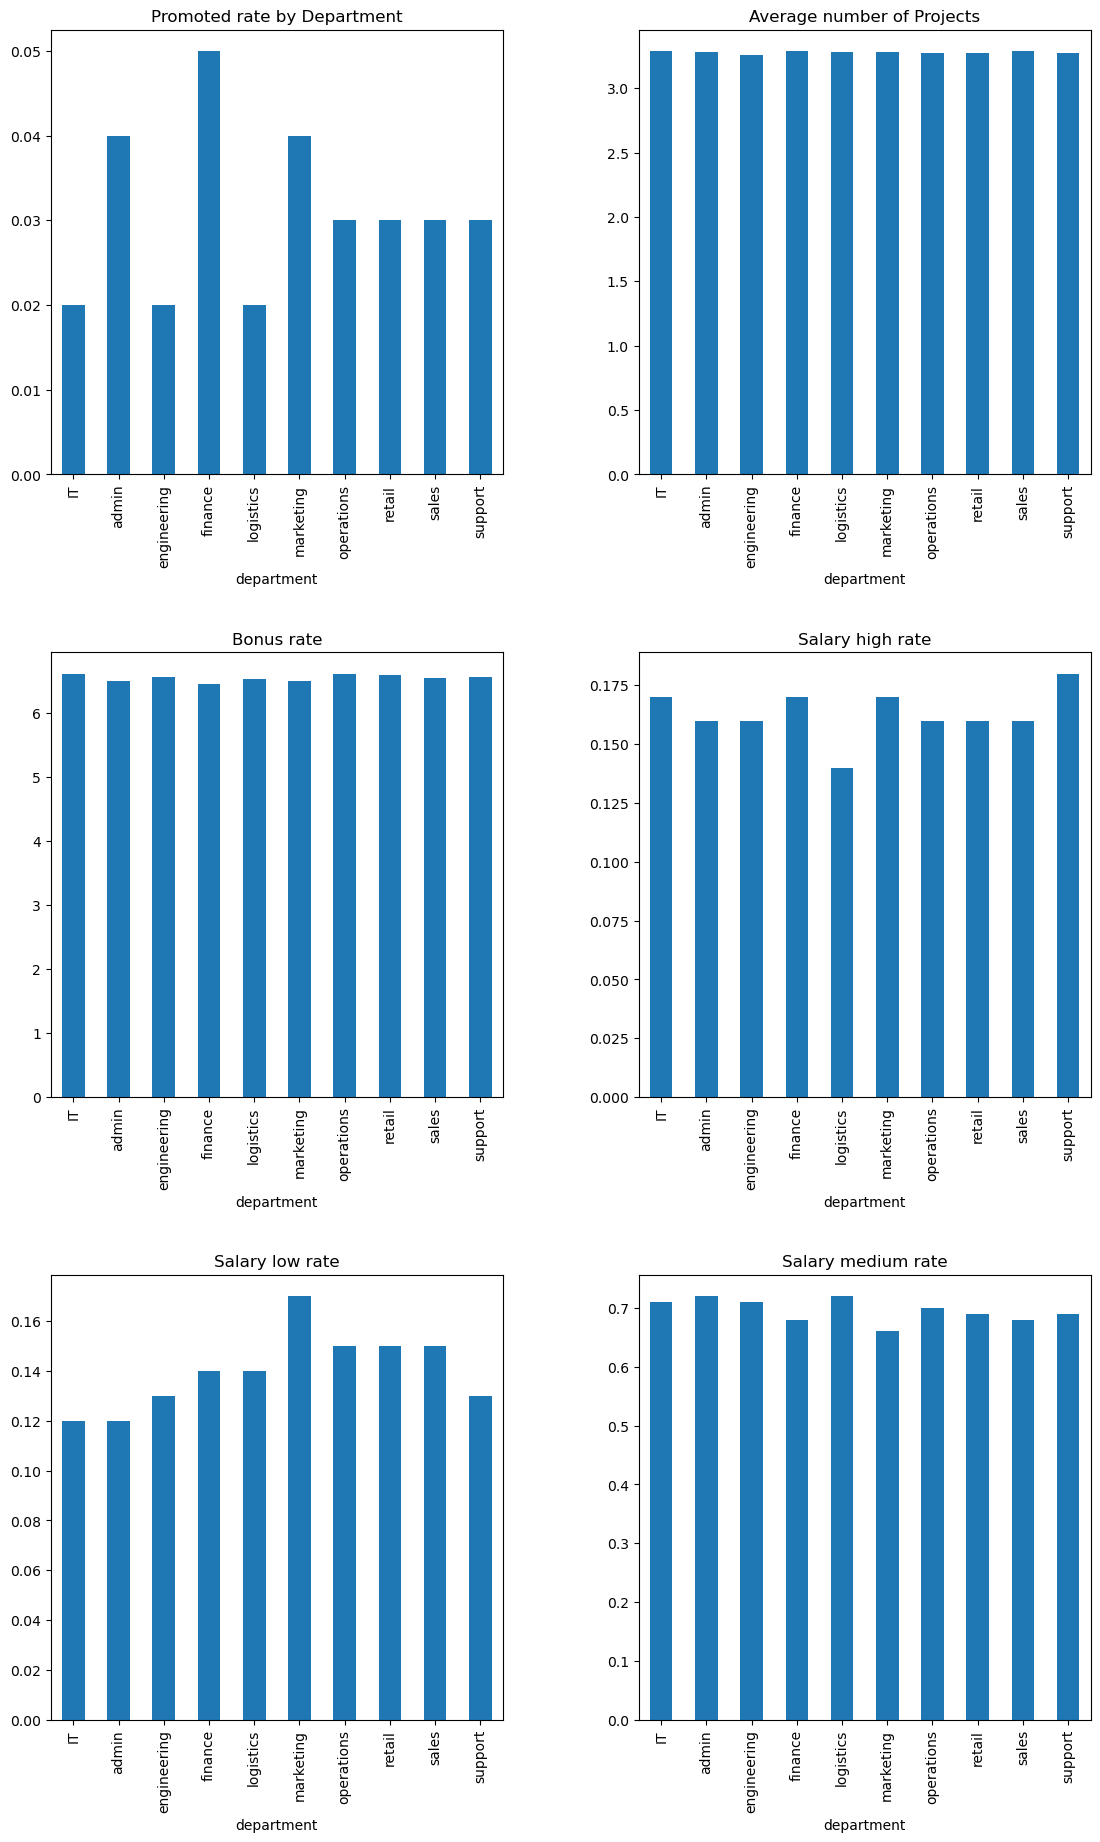

In [79]:
plt.figure(figsize=(13,13))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)


# 'promoted' rate
plt.subplot(3,2,1)
promoted_by_depart = depart_status['promoted']
promoted_by_depart.plot(kind='bar')
plt.title('Promoted rate by Department')

# Average number of Projects
plt.subplot(3,2,2)
projects_by_depart = depart_status['projects']
projects_by_depart.plot(kind='bar')
plt.title('Average number of Projects')

# Average Tenure 
plt.subplot(3,2,3)
tenure_by_depart = depart_status['tenure']
tenure_by_depart.plot(kind='bar')
plt.title('Average Tenure')

# 'bonus' rate
plt.subplot(3,2,3)
bonus_by_depart = depart_status['bonus']
bonus_by_depart.plot(kind='bar')
plt.title('Bonus rate')

# Salary_high rate 
plt.subplot(3,2,4)
sal_high_by_depart = depart_status['sal_high']
sal_high_by_depart.plot(kind='bar')
plt.title('Salary high rate')

# Salary_low rate 
plt.subplot(3,2,5)
sal_low_by_depart = depart_status['sal_low']
sal_low_by_depart.plot(kind='bar')
plt.title('Salary low rate')

# Salary_medium rate 
plt.subplot(3,2,6)
sal_mid_by_depart = depart_status['sal_mid']
sal_mid_by_depart.plot(kind='bar')
plt.title('Salary medium rate')

plt.subplot(3,2,6)
plt.show()

# miscellaneous

- who's got promoted?
- who's got a bonus?
- how's the working pattern by tenure?